In [2]:
import numpy as np
import pandas as pd
import glob
import locale
import os.path
import requests
import sys
import codecs
from smart_open import smart_open
import re
import spacy
import string
import pickle as pkl
import torch
from torch.utils.data import Dataset
import random
import matplotlib.pyplot as plt
import copy 

In [3]:
def load_IMDB(folderpath, pos = True):
    read_files = glob.glob(folderpath)
    data_dict = {}
    data_dict['data'] = []
    data_dict['target'] = []
    data_dict['filenames']= []
    if pos:
        target_value = 1
    else: 
        target_value = 0
    for f in read_files:
        with open(f, "rb") as infile:
            data_dict['data'].append(infile.read().decode("utf-8"))
            data_dict['target'].append(target_value)
            data_dict['filenames'].append(f)
    return data_dict

In [4]:
train_pos = load_IMDB("aclImdb-2/train/pos/*.txt", pos = True)
train_neg = load_IMDB("aclImdb-2/train/neg/*.txt", pos = False)
test_pos = load_IMDB("aclImdb-2/test/pos/*.txt", pos = True)
test_neg = load_IMDB("aclImdb-2/test/neg/*.txt", pos = False)
# Split train data into actual train and validation sets

train_split = 10000
train_data = train_pos['data'][:train_split] +  train_neg['data'][:train_split]
train_targets = train_pos['target'][:train_split] +  train_neg['target'][:train_split]

val_data = train_pos['data'][train_split:] +  train_neg['data'][train_split:]
val_targets = train_pos['target'][train_split:] +  train_neg['target'][train_split:]

test_data = test_pos['data']+  test_neg['data']
test_targets = test_pos['target']+  test_neg['target']

print ("Train dataset size is {}".format(len(train_data)))
print ("Val dataset size is {}".format(len(val_data)))
print ("Test dataset size is {}".format(len(test_data)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [5]:
print(train_data[100])
print(train_targets[100])

Sure, it was cheesy and nonsensical and at times corny, but at least the filmmakers didn't try. While most TV movies border on the brink of mediocrity, this film actually has some redeeming qualities to it. The cinematography was pretty good for a TV film, and Viggo Mortensen displays shades of Aragorn in a film about a man who played by his own rules. Most of the flashback sequences were kind of cheesy, but the scene with the mountain lion was intense. I was kind of annoyed by Jason Priestly's role in the film as a rebellious shock-jock, but then again, it's a TV MOVIE! Despite all of the good things, the soundtrack was atrocious. However, it was nice to see Tucson, Arizona prominently featured in the film.
1


In [25]:
# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent):
    tokens = tokenizer(sent)
    return [token.text for token in tokens]

def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample)
        token_dataset.append(tokens)
        all_tokens += tokens
    return token_dataset, all_tokens
#valication set tokens
print ("Tokenizing val data")
val_data_tokens, _ = tokenize_dataset(val_data)
#test set tokens
print ("Tokenizing test data")
test_data_tokens, _ = tokenize_dataset(test_data)

#train set tokens
print ("Tokenizing train data")
train_data_tokens, all_train_tokens = tokenize_dataset(train_data)

Tokenizing val data
Tokenizing test data
Tokenizing train data


In [26]:
from collections import Counter

# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens, max_vocab_size = 10000):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens, max_vocab_size = 20000)

random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 1035 ; token ideas
Token ideas; token id 1035


In [27]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [10]:
sentence_len = []
for i in range(len(train_data_indices)):
    sentence_len.append(len(train_data_indices[i]))
print('The maximum sentense length is',max(sentence_len))

The maximum sentense length is 2789


In [29]:
MAX_SENTENCE_LENGTH = max(sentence_len)

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

In [12]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

In [30]:
learning_rate = 0.01
num_epochs = 3 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = len(train_loader))

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

#################
val_acc_l_LR_noclean= []
#################
step_l = []
loss_l = []
loss_step = []
for epoch in range(num_epochs):
    #scheduler.step(epoch)
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        # have to zero them out at the start of a new minibatch
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss_l.append(loss)
        loss_step.append(i)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 50 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            #################
            val_acc_l_LR_noclean.append(val_acc)
            #################
            step_l.append(i+1) 
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
f = [0]*12
f.extend([625]*12)
f.extend([2*625]*12)
step_l= [x + y for x, y in zip(f, step_l)]

Epoch: [1/3], Step: [51/625], Validation Acc: 69.4
Epoch: [1/3], Step: [101/625], Validation Acc: 81.5
Epoch: [1/3], Step: [151/625], Validation Acc: 84.86
Epoch: [1/3], Step: [201/625], Validation Acc: 85.54
Epoch: [1/3], Step: [251/625], Validation Acc: 87.18
Epoch: [1/3], Step: [301/625], Validation Acc: 87.32
Epoch: [1/3], Step: [351/625], Validation Acc: 86.44
Epoch: [1/3], Step: [401/625], Validation Acc: 88.06
Epoch: [1/3], Step: [451/625], Validation Acc: 87.8
Epoch: [1/3], Step: [501/625], Validation Acc: 88.56
Epoch: [1/3], Step: [551/625], Validation Acc: 89.2
Epoch: [1/3], Step: [601/625], Validation Acc: 88.44
Epoch: [2/3], Step: [51/625], Validation Acc: 88.9
Epoch: [2/3], Step: [101/625], Validation Acc: 89.02
Epoch: [2/3], Step: [151/625], Validation Acc: 88.62
Epoch: [2/3], Step: [201/625], Validation Acc: 88.76
Epoch: [2/3], Step: [251/625], Validation Acc: 88.98
Epoch: [2/3], Step: [301/625], Validation Acc: 88.48
Epoch: [2/3], Step: [351/625], Validation Acc: 88.68


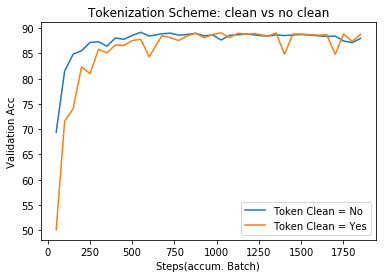

In [31]:
# visualization 
plt.plot(step_l,val_acc_l_LR_noclean,label = 'Token Clean = No')
plt.plot(step_l,val_acc_l_LR_dic20000,label = 'Token Clean = Yes')
plt.xlabel('Steps(accum. Batch)')
plt.ylabel('Validation Acc')
plt.title('Tokenization Scheme: clean vs no clean')
plt.legend()
plt.show()

In [32]:
max(val_acc_l_LR_dic20000)

89.08